In [75]:
import numpy as np
import scipy as sp
from skimage import io
import matplotlib.pyplot as plt

BLACK = 252
WHITE = 4095
R_SCALE = 1.667969
G_SCALE = 1.000000
B_SCALE = 1.445313

gamma = 2.2

In [76]:
im = io.imread('data/campus.tiff')

# plt.imshow(im) # display image


In [77]:
im

array([[283, 318, 290, ..., 291, 273, 296],
       [319, 288, 331, ..., 278, 294, 279],
       [290, 329, 295, ..., 286, 274, 293],
       ...,
       [302, 284, 306, ..., 328, 459, 331],
       [274, 306, 275, ..., 466, 355, 472],
       [306, 284, 305, ..., 330, 479, 330]],
      shape=(4040, 6064), dtype=uint16)

In [78]:
np.max(im)

np.uint16(4095)

In [79]:
im = im.astype(np.float32)

In [80]:
im -= np.ones_like(im) * BLACK
im /= (WHITE - BLACK)
np.clip(im, 0, 1, out=im)

array([[0.00806661, 0.01717408, 0.00988811, ..., 0.01014832, 0.00546448,
        0.01144939],
       [0.0174343 , 0.00936768, 0.02055686, ..., 0.00676555, 0.01092896,
        0.00702576],
       [0.00988811, 0.02003643, 0.01118917, ..., 0.00884725, 0.00572469,
        0.01066875],
       ...,
       [0.01301067, 0.00832683, 0.01405152, ..., 0.01977622, 0.05386417,
        0.02055686],
       [0.00572469, 0.01405152, 0.00598491, ..., 0.05568566, 0.02680198,
        0.05724694],
       [0.01405152, 0.00832683, 0.01379131, ..., 0.02029664, 0.05906844,
        0.02029664]], shape=(4040, 6064), dtype=float32)

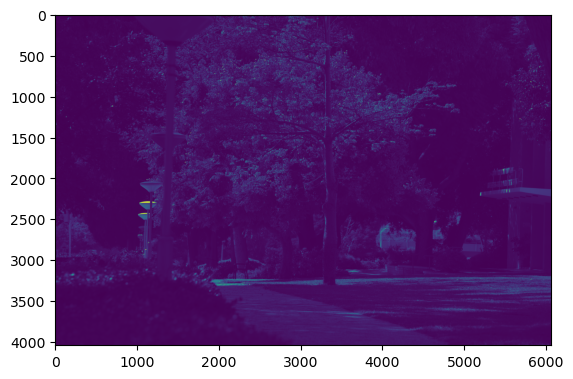

In [81]:
plt.imshow(im)

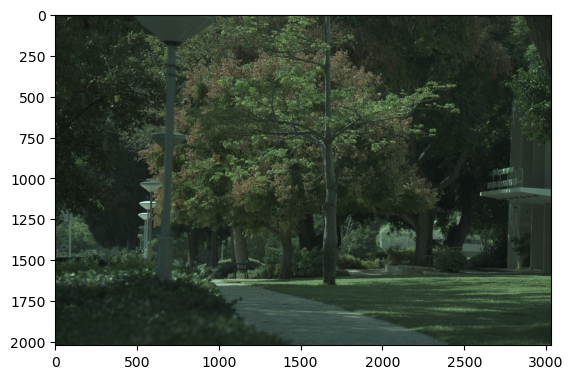

In [82]:
def to_rgb(image):
    """Convert a Bayer image to RGB image
    Input:
        im: H x W array"""
    im1 = image[0::2, 0::2]
    im2 = image[0::2, 1::2]
    im3 = image[1::2, 0::2]
    im4 = image[1::2, 1::2]
    im_rgb = np.dstack((im1, im3, im4))
    return im_rgb

plt.imshow(to_rgb(im)** (1/gamma))

## White Balance

In [83]:
def white_world_assumption(image):
    """White world assumption
    Input:
        image: H x W x 3 array"""
    image = image.copy()
    im1 = image[0::2, 0::2]
    im2 = image[0::2, 1::2]
    im3 = image[1::2, 0::2]
    im4 = image[1::2, 1::2]
    r_max = np.max(im1) # Red=im1
    g_max = np.max([np.max(im2),np.max(im3)]) # Green=im2,im3
    b_max = np.max(im4) # Blue=im4
    im_red_normalized = im1 * g_max / r_max
    im_blue_normalized = im4 * g_max / b_max
    image[0::2, 0::2] = im_red_normalized
    image[1::2, 1::2] = im_blue_normalized
    return image
    
def scale_channels(image):
    """Scale channels according to given scales
    Input:
        image: H x W x 3 array"""
    image = image.copy()
    image[0::2, 0::2] *= R_SCALE
    image[0::2, 1::2] *= G_SCALE
    image[1::2, 0::2] *= G_SCALE
    image[1::2, 1::2] *= B_SCALE
    return image

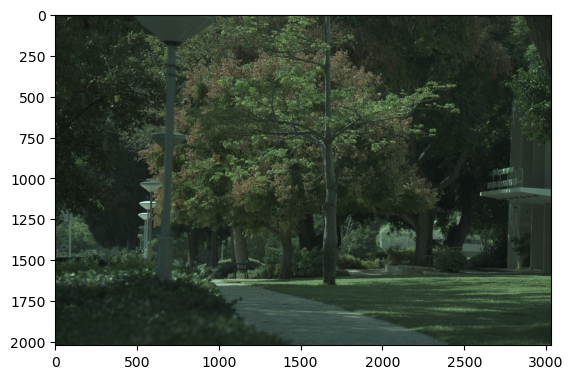

In [84]:
plt.imshow(to_rgb(white_world_assumption(im)) ** (1/gamma))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2618116].


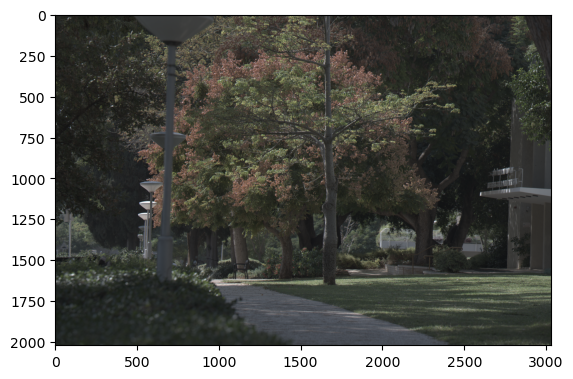

In [85]:
plt.imshow(to_rgb(scale_channels(im)) ** (1/gamma))

## Interpolation

In [86]:
# len(im[0,:]), len(im[:,0])
im_red = im[0::2, 0::2]
im_blue = im[1::2, 1::2]
im_green1 = im[0::2, 1::2]
im_green2 = im[1::2, 0::2]

In [87]:
im_red.shape

(2020, 3032)

In [88]:
x = np.arange(0, im.shape[1],2)
y = np.arange(0, im.shape[0],2)

X_full, Y_full = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0]))

In [89]:
# interpolate each component
interp = sp.interpolate.RegularGridInterpolator((y, x), im_red, fill_value=None, bounds_error=False)
red_full_image = interp((Y_full, X_full))
print('Red done')

interp = sp.interpolate.RegularGridInterpolator((y + 1, x + 1), im_blue, fill_value=None, bounds_error=False)
blue_full_image = interp((Y_full, X_full))
print('Blue done')

interp = sp.interpolate.RegularGridInterpolator((y, x + 1), im_green1, fill_value=None, bounds_error=False)
green1_full_image = interp((Y_full, X_full))
print('Green1 done')

interp = sp.interpolate.RegularGridInterpolator((y + 1, x), im_green2, fill_value=None, bounds_error=False)
green2_full_image = interp((Y_full, X_full))

Red done
Blue done
Green1 done


In [90]:
green_full_image = 0.5 * (green1_full_image + green2_full_image)
full_image = np.dstack((red_full_image, green_full_image, blue_full_image))

C:\Users\Chaya\AppData\Local\Temp\ipykernel_2512\2278368778.py:1: RuntimeWarning: invalid value encountered in power
  plt.imshow(full_image ** (1/gamma))


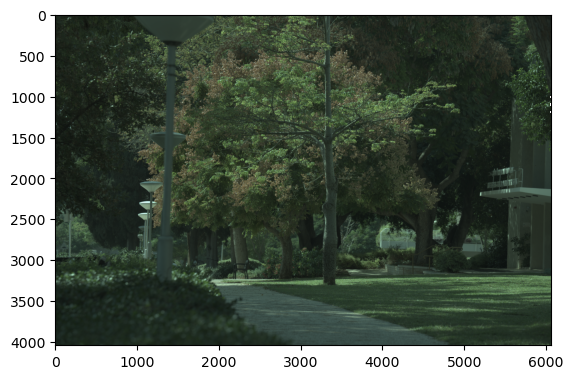

In [91]:
plt.imshow(full_image ** (1/gamma))

## Brighting Up the Image

In [108]:
p = 99
value_to_scale = np.percentile(full_image, p)
bright_full_image = full_image.copy()
bright_full_image /= value_to_scale
bright_full_image = np.clip(bright_full_image, 0, 1)

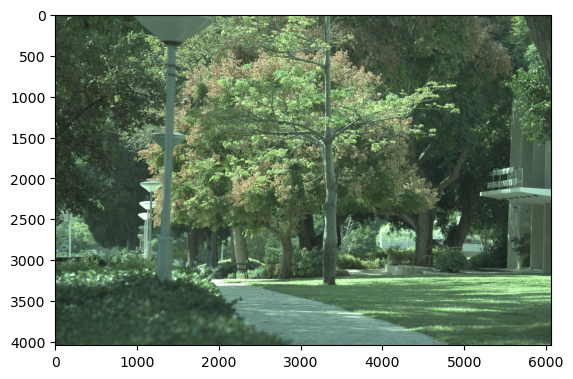

In [109]:
plt.imshow(bright_full_image ** (1/gamma))

C:\Users\Chaya\AppData\Local\Temp\ipykernel_2512\2284320997.py:3: RuntimeWarning: invalid value encountered in power
  plt.imshow(full_image ** (1/gamma))


AttributeError: 'Figure' object has no attribute 'title'

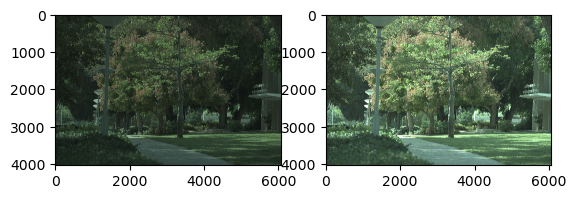

In [ ]:
fig = plt.figure()
fig.add_subplot(1, 2, 1) 
plt.imshow(full_image ** (1/gamma))
fig.add_subplot(1, 2, 2)
plt.imshow(bright_full_image ** (1/gamma))
plt.title(f'Original vs Brightened (Percentile {p})')
plt.show()